In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


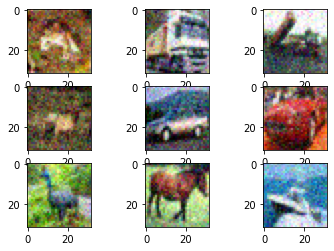

In [3]:
from tensorflow.keras.datasets import cifar10

(trainX, trainy), (testX, testy) = cifar10.load_data()
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(trainX[i][:,::-1, :]/255 + np.random.normal(size=trainX[i][:,::-1, :].shape) * 1e-1)

plt.show()

In [4]:
n_data = 100
train_images = trainX[:n_data]
train_labels = pd.get_dummies(trainy[:n_data,0]).values
test_images = testX[:n_data]
test_labels = pd.get_dummies(testy[:n_data,0]).values
n_cls = train_labels.shape[1]

In [11]:
train_images.shape

(100, 32, 32, 3)

In [88]:
style = 'conv'

In [103]:
if style == 'fc':
    x = train_images.reshape(train_images.shape[0], -1)
    x_tst = test_images.reshape(test_images.shape[0], -1)
    num_features = x.shape[1]
else:
    x = train_images
    x_tst = test_images
    num_features = 3
x_mean, x_std = x.mean(), x.std()
x = (x - x_mean) / x_std
x_tst = (x_tst - x_mean)/ x_std
y = train_labels
y_tst = test_labels

In [104]:
class LeakyRelu:
    def __init__(self):
        pass
    def forward(self, x):
        self.x_last = x
        ret = np.maximum(x, .3 * x)
        return ret
    def backward(self, err, *args, **kwargs):
        return err * ((self.x_last > 0) + (self.x_last < 0) * .3)


In [105]:
class FlattenNp:
    def __init__(self):
        pass
    def forward(self, x):
        # reshape x shape [bs, h, w, filters] to [bs, -1]
        self.bs, self.h, self.w, self.filters = x.shape
        return x.reshape(bs, -1)
    
    def backward(self, err, *args, **kwargs):
        # input: [bs, -1]
        # output: [bs, h, w, filters]
        return err.reshape(self.bs, self.h, self.w, self.filters)

In [106]:
class DenseNp:
    def __init__(self, in_shape, out_shape, l2_reg = 1e-5, initialization = 'xavier', momentum = 0.0,
                nesterov = False):
        self.nesterov = nesterov
        self.l2_reg = l2_reg
        self.momentum = momentum
        self.w = np.random.randn(in_shape, out_shape)
        if initialization == 'xavier':
            self.w = self.w * np.sqrt(6) / np.sqrt(in_shape + out_shape)
        self.b = np.random.randn(out_shape)/out_shape
        if momentum >0:
            self.w_vel = np.zeros_like(self.w)
            self.b_vel = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x_last = x
        if self.nesterov:
            self.w = self.w + self.w_vel * self.momentum
            self.b = self.b + self.b_vel * self.momentum
        ret = x @ self.w + self.b
        return ret
    def backward(self, err, lr):
        if len(err.shape) < 2:
            err = err[:, None]
        grad_backward = err @ self.w.T
        if self.momentum == 0:
            self.w = self.w +  ((self.x_last.T @ err) - self.l2_reg * self.w) * lr
            # err has shape (bs, out_features)
            # beta_update has shape (out_features)
            beta_update = err.sum(0)
            self.b = self.b + beta_update * lr
        else:
            self.w_vel = self.w_vel * self.momentum +  (
                (self.x_last.T @ err) - self.l2_reg * self.w) * (1- self.momentum) * lr
            self.b_vel = self.b_vel * self.momentum + err.sum(0) * (1- self.momentum) * lr
            if self.nesterov:
                self.w += ((self.x_last.T @ err) - self.l2_reg * self.w) * (1- self.momentum) * lr
                self.b += err.sum(0) * (1- self.momentum) * lr
            else:
                self.w += self.w_vel
                self.b += self.b_vel

        return grad_backward

In [107]:
class ConvNp:
    def __init__(self, in_shape, out_shape, l2_reg = 1e-5, initialization = 'kaiming', momentum = 0.0,
                nesterov = False, kernel_size = 3, padding=True):
        if nesterov:
            raise NotImplementedError('nesterov not yet implemented')
        if momentum > 0:
            raise NotImplementedError('momentum not yet implemented')
        self.padding = padding
        self.kernel_size = kernel_size
        self.nesterov = nesterov
        self.l2_reg = l2_reg
        self.momentum = momentum
        self.w = np.random.randn(kernel_size, kernel_size, in_shape, out_shape)
        if initialization == 'xavier':
            self.w = self.w * np.sqrt(6) / np.sqrt(in_shape + out_shape)
        if initialization == 'kaiming':
            self.w = self.w * np.sqrt(2 / in_shape)
            self.b = np.zeros((out_shape))
        else:
            self.b = np.random.randn(out_shape)/out_shape
        if momentum >0:
            self.w_vel = np.zeros_like(self.w)
            self.b_vel = np.zeros_like(self.b)
        
    def forward(self, x):
        # batch_size, h, w, features
        pad = int((self.kernel_size - 1)/2)
        bs, h, w, n_in = x.shape
        x_pad = np.concatenate((np.zeros((bs, 1, w, n_in)), x, np.zeros((bs, 1, w, n_in))), axis=1)
        x_pad = np.concatenate((np.zeros((bs, h+pad * 2, 1, n_in)), x_pad, np.zeros((bs, h+pad * 2, 1, n_in))), axis=2)
        self.x_last = x
#         if self.nesterov:
#             self.w = self.w + self.w_vel * self.momentum
#             self.b = self.b + self.b_vel * self.momentum
        output = np.zeros((bs, h, w, self.out_shape))
        for i in range(h):
            for j in range(w):
                h_start, w_start = i, j
                h_end, w_end = h_start + kernel_size, w_start + kernel_size
                # batch size, kernel_height, kernel width, in_filters, output_filters
                output_val = np.sum(
                    x_pad[:, h_start:h_end, w_start:w_end, :, None] *
                    self.w[None, :, :, :, :],
                    axis=(1, 2, 3)
                )
                # output val shape: batch_size, output_filters
                output[:, i, j, :] = output_val
        # batch, h, w, out_filters
        return output + self.b[None, None, None, :]
    def backward(self, err, lr):
        if len(err.shape) < 2:
            err = err[:, None]
        # err: batch, h, w, out_filters
        # grad_backward: batch, h, w, in_filters
#         grad_backward = err @ self.w.T
        bs, h, w, n_out = err.shape
        grad_w = np.zeros((bs, h, w, self.in_shape))
        e_pad = np.concatenate((np.zeros((bs, 1, w, n_out)), err, np.zeros((bs, 1, w, n_out))), axis=1)
        e_pad = np.concatenate((np.zeros((bs, h+pad * 2, 1, n_out)), e_pad, np.zeros((bs, h+pad * 2, 1, n_out))), axis=2)
        for i in range(h):
            for j in range(w):
                h_start, w_start = i, j
                h_end, w_end = h_start + kernel_size, w_start + kernel_size
                # batch size, kernel_height, kernel width, in_filters, output_filters
                output_val = np.sum(
                    e_pad[:, h_start:h_end, w_start:w_end, None, :] *
                    self.w[None, :, :, :, :],
                    axis=(1, 2, 4)
                )
                # output val shape: batch_size, input_filters
                grad_w[:, i, j, :] = output_val
        
        # err has shape (bs, h, w, out_features)
        # beta_update has shape (out_features)
        beta_update = np.sum(err, axis=(0, 1, 2))
        if self.momentum == 0:
            self.w = self.w +  (grad_w - self.l2_reg * self.w) * lr
            self.b = self.b + beta_update * lr
        else:
            self.w_vel = self.w_vel * self.momentum +  (
                (self.x_last.T @ err) - self.l2_reg * self.w) * (1- self.momentum) * lr
            self.b_vel = self.b_vel * self.momentum + err.sum(0) * (1- self.momentum) * lr
            if self.nesterov:
                self.w += ((self.x_last.T @ err) - self.l2_reg * self.w) * (1- self.momentum) * lr
                self.b += err.sum(0) * (1- self.momentum) * lr
            else:
                self.w += self.w_vel
                self.b += self.b_vel

        return grad_backward

In [108]:
class Model:
    def __init__(self, layer_shapes, lr = 1e-1, momentum = 0.0, style = 'fc', target_shape = None):
        self.lr = lr
        self.style = style
        self.losses = []
        self.layers = []
        for in_shape, out_shape in zip(layer_shapes[:-1], layer_shapes[1:]):
            if style == 'fc':
                self.layers.append(DenseNp(in_shape, out_shape, momentum = momentum))
            elif style == 'conv':
                self.layers.append(ConvNp(in_shape, out_shape, momentum = momentum))
                
            self.layers.append(LeakyRelu())
        if style == 'conv':
            self.layers.append(FlattenNp())
            self.layers.append(LeakyRelu())
            self.layers.append(DenseNp(layer_shapes[-1], target_shape, momentum = momentum))
        else:
            self.layers = self.layers[:-1]
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def loss(self, x = None, y= None, err = None):
        if err is None:
            err = self.err(x, y)
        return np.square(err).mean()
    
    def err(self, x, y):
        yhat = self.predict(x)
        return (y - yhat)
#     def backprop(grad_output):
        
        
    def train_fullbatch(self, x, y, steps, **kwargs):
        
        for step in range(steps):
            err = self.err(x, y)
            self.losses.append(self.loss(err = err))
            grad_layer = err / y.shape[0]
            for layer in self.layers[::-1]:
                grad_layer = layer.backward(grad_layer, lr = self.lr)
            
    def train_one_epoch(self, x, y, batch_size):
        data_order = np.random.choice(x.shape[0], x.shape[0], replace=False)
        num_batch = x.shape[0]//batch_size
        minibatch_losses = 0
        for batch_idx in range(num_batch):
            if batch_idx == num_batch - 1:
                sample_idxs = data_order[batch_idx * batch_size:]
            else:
                sample_idxs = data_order[batch_idx * batch_size: (batch_idx + 1) * batch_size]
            x_sample = x[sample_idxs]
            y_sample = y[sample_idxs]
            err = self.err(x_sample, y_sample)
            minibatch_losses += self.loss(err = err)
            grad_layer = err / y_sample.shape[0]
            for layer in self.layers[::-1]:
                grad_layer = layer.backward(grad_layer, lr = self.lr)
        self.losses.append(minibatch_losses)
        
        
    def train_minibatch(self, x, y, epochs, batch_size = 8):
        for epoch in range(epochs):
            self.train_one_epoch(x, y, batch_size = batch_size)
        
    def train(self, x, y, steps, style = 'fullbatch', **kwargs):
        {'minibatch': self.train_minibatch, 'fullbatch': self.train_fullbatch}[style](x, y, steps, **kwargs)
    def viz(self, skip_first = 0):
        plt.plot(self.losses[skip_first:])

In [109]:
mdl = Model([num_features, 16, 16], momentum = 0, lr = 1e-6, style = style, target_shape = y.shape[1])

In [110]:
mdl.train(x, y,1000 , style = 'minibatch')

AttributeError: 'ConvNp' object has no attribute 'out_shape'

In [46]:
[np.square(layer.w).mean() for layer in mdl.layers if hasattr(layer, 'w')]

[0.0019252282328346409, 0.19127080248261052, 0.2105331418938987]

In [13]:
[np.square(layer.x_last).mean() for layer in mdl.layers]

[1.0201818464696755,
 2.8861608065230246,
 1.895767446480646,
 27.971203838916477,
 4.561471530670049]

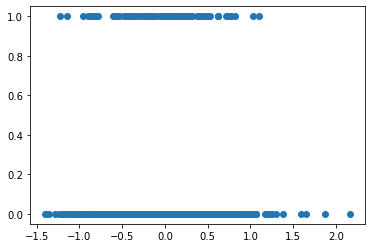

In [62]:
plt.scatter(mdl.predict(x), y)

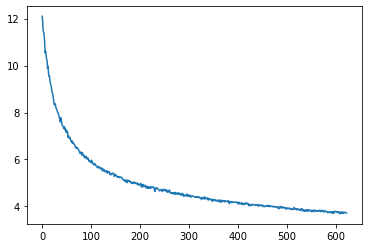

In [61]:
mdl.viz(skip_first = 20)

In [16]:
.00001

1e-05

In [17]:
x = np.arange(-12, 12, .001)
np.log(1+np.exp(x))

array([6.14419348e-06, 6.15034073e-06, 6.15649412e-06, ...,
       1.19970062e+01, 1.19980062e+01, 1.19990062e+01])

In [18]:
mdl.losses[-1]

1.183235400175535

In [19]:
from sklearn.linear_model import Ridge
baseline = Ridge().fit(x, y)
yhat = baseline.predict(x)
np.square(yhat - y).mean()

ValueError: Expected 2D array, got 1D array instead:
array=[-12.    -11.999 -11.998 ...  11.997  11.998  11.999].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
mdl.loss(x, y[:,None])